### Generating fonts with GANs

This simple example shows how one can easily implement & train generative adversarial networks in Lasagne.

![img](https://thepipsqueaker.files.wordpress.com/2013/02/we-all-know-this-looks-bad.jpg)

For ages, designers made countless weird fonts of all kinds and shapes. We engineers, however, can't even tell one font for the other when the designer next door comes to tease us. So finally, let's teach these pesky designers a lesson!

First, we need some fonts to train on. A few (hundred) thousands, preferably. Luckily, there's just such a dataset: [NotMNIST](http://yaroslavvb.blogspot.ru/2011/09/notmnist-dataset.html).

In the next cell, we download and unpack it using wget and tar. If you don't have them, just load the dataset from [that blog again](http://yaroslavvb.blogspot.ru/2011/09/notmnist-dataset.html) and extract it: there should be a "notMNIST_small" folder in current workdir, containing folders with letter images.


__If we can't make a font, we delegate it to a neural network.__ So here it goes: a neural network to generate fonts from random inputs.


In [1]:
#notmnist small
!wget -N http://yaroslavvb.com/upload/notMNIST/notMNIST_small.tar.gz
!tar -zxvf notMNIST_small.tar.gz > untar_notmnist.log

--2017-01-09 09:08:24--  http://yaroslavvb.com/upload/notMNIST/notMNIST_small.tar.gz
Resolving yaroslavvb.com (yaroslavvb.com)... 129.121.4.193
Connecting to yaroslavvb.com (yaroslavvb.com)|129.121.4.193|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8458043 (8.1M) [application/x-gzip]
Saving to: ‘notMNIST_small.tar.gz’

100%[======================================>] 8,458,043   2.06MB/s   in 3.9s   

2017-01-09 09:08:28 (2.06 MB/s) - ‘notMNIST_small.tar.gz’ saved [8458043/8458043]



In [2]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams.update({'axes.titlesize': 'small'})
import numpy as np
IMG_SHAPE = (28,28)

In [3]:
from scipy.misc import imread,imresize
from glob import glob

data = []
for path in glob('./notMNIST_small/*/*'):
    try:
        data.append(imresize(imread(path),IMG_SHAPE))
    except:
        print "failed:",path
        
data = np.stack(data)[:,None]
data = data.astype(np.float32)
data = (data - np.mean(data))/np.std(data)/16.

failed: ./notMNIST_small/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png
failed: ./notMNIST_small/F/Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png


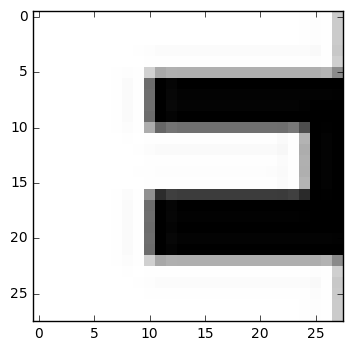

In [4]:
#print random image
plt.imshow(data[np.random.randint(data.shape[0]),0], cmap="gray", interpolation="none")

# Generative models 101

<img src="https://raw.githubusercontent.com/torch/torch.github.io/master/blog/_posts/images/model.png" width=320px height=240px>

Deep learning is simple, isn't it? 
* build some network that produces the font (small image)
* make up a __measure__ of __how good your font is__
* if you have gradients, optimize with gradient descent
* if you don't, cry with bloody tears or try REINFORCE.

The only problem is: how can we engineers tell good fonts from bad? And i bet you we won't ask a designer for help. 

__If we can't tell good fonts from bad, we delegate it to yet another neural network!__

That makes the two of them:
* __G__enerator - takes random noize for inspiration and tries to generate a font sample. 
  * Let's call him __G__(z), where z is a gaussian noize.
* __D__iscriminator - takes a font sample and tries to tell if it's great or fake. 
  * Predicts the probability of input image being a __real font__
  * Let's call him __D__(x), x being an image.
  * __D(x)__ is a predition for real image and __D(G(z))__ is prediction for the font made by generator.

Before we dive into training them, let's construct the two networks.

In [5]:
%env THEANO_FLAGS=device=gpu,floatX=float32
import theano
import theano.tensor as T
inputZ = T.matrix('generator noize')
inputX = T.tensor4('real images') # [batch_size, num_channels, height, width]


env: THEANO_FLAGS=device=gpu6,floatX=float32


Using gpu device 6: GeForce GTX 1080 (CNMeM is enabled with initial size: 45.0% of memory, cuDNN 5105)


In [7]:
import lasagne
from lasagne.layers import *
from lasagne.regularization import regularize_layer_params, l2

class generator:
    CODE_SIZE = 128 # size of normal noise
    
    l_in = InputLayer((None, CODE_SIZE),input_var=inputZ,name='g_input')

    l_dense = DenseLayer(l_in,10*8*8,nonlinearity=T.tanh,name = 'g_dense')
    
    l_reshape = ReshapeLayer(l_dense, (-1, 10, 8, 8), name='g_reshape')
    
    l_deconv0 = Deconv2DLayer(l_reshape, 128, 5, name='g_deconv0')
    
    l_upscale = Upscale2DLayer(l_deconv0, 2,name='g_upscale')
    
    l_deconv1 = Deconv2DLayer(l_upscale, 64, 3, name='g_deconv1')
    
    l_deconv2 = Deconv2DLayer(l_deconv1, 32, 3, name='g_deconv2')
    
    l_deconv3 = Deconv2DLayer(l_deconv2, 32, 3, name='g_deconv3')

    l_gen = Conv2DLayer(l_deconv3, 1, 3, nonlinearity=None, name='g_deconv_out')
    
    
    assert len(l_gen.output_shape)==4 and l_gen.output_shape[1:] == (1,)+IMG_SHAPE    
    weights = get_all_params(l_gen, trainable=True)
    
    sample = theano.function([inputZ],get_output(l_gen))


### Discriminator
* Discriminator is a casual convolutional network with interlooping convolution and pooling layers
* The network does not include dropout/batchnorm to avoid learning complications.
* We also regularize the pre-output layer to prevent discriminator from being too certain.

In [8]:
from lasagne.init import Normal #since bad init can blow the network up =c
class discriminator:
    
    #image: real or generated
    l_in = InputLayer((None, 1, IMG_SHAPE[0], IMG_SHAPE[1]), name='d_input')
    
    #network body
    l_conv0 = Conv2DLayer(l_in, 32, 5)
    l_pooling0 = Pool2DLayer(l_conv0, 3)
    l_conv1 = Conv2DLayer(l_pooling0, 64, 5)
    l_dense0 = DenseLayer(l_conv1, 128,nonlinearity=T.tanh)
    
    #predicted probability of image being REAL
    l_prob = DenseLayer(l_dense0,1,W = Normal(1e-3),
                        nonlinearity=T.nnet.sigmoid) #P(real|x)
    
    #auxilary stuff
    regularization = regularize_layer_params(l_prob, l2)*1e-4
    
    weights = get_all_params(l_prob, trainable=True)
    
    predict = theano.function([inputX],get_output(l_prob,inputX))
    

# Training

We train the two networks concurrently:
* Train __discriminator__ to better distinguish real data from __current__ generator
* Train __generator__ to make discriminator think generator is real
* Since discriminator is a differentiable neural network, we train both with gradient descent.

![img](https://s24.postimg.org/usx5ubout/gan.png)

Training is done iteratively until discriminator is no longer able to find the difference (or until you run out of patience).

The more detailed (and by far more academic) description of how to train GANs can be found in [the original article](https://arxiv.org/abs/1406.2661) or in [this tutorial](https://arxiv.org/pdf/1701.00160v1.pdf).



### Tricks:
* We clip too certain probabilities from discriminator to avoid numerical instability
* We train with __adagrad__ since it's a very simple optimization method that reduces learning rate over time
* We compile two functions here to train generator and discriminator respectively


In [9]:
class training:
    
    #D(data)
    p_real_is_real = get_output(discriminator.l_prob, inputs=inputX)
    
    #D(G(z))
    generated_img = get_output(generator.l_gen)
    p_gen_is_real = get_output(discriminator.l_prob, generated_img)
    
    ########################
    ###generator training###
    ########################
    
    g_loss = -T.log(p_gen_is_real).mean()
    g_updates = lasagne.updates.adagrad(g_loss, generator.weights, 0.01)
    g_train_step = theano.function([inputZ], g_loss, updates=g_updates, allow_input_downcast=True)

    
    ########################
    #discriminator training#
    ########################
    d_loss = -(T.log(p_real_is_real) + T.log(1-p_gen_is_real)).mean() + discriminator.regularization

    d_updates = lasagne.updates.adagrad(d_loss, discriminator.weights, 0.01)
    d_train_step = theano.function([inputX, inputZ], d_loss, updates=d_updates, allow_input_downcast=True)
    

### Auxilary functions
Here we define a few helper functions that draw current data distributions and sample training batches.

In [12]:
def sample_noise_batch(bsize):
    return np.random.normal(size=(bsize, generator.CODE_SIZE)).astype('float32')

def sample_data_batch(bsize):
    idxs = np.random.choice(np.arange(data.shape[0]), size=bsize)
    return data[idxs]

def sample_images(nrow,ncol, sharp=False):
    images = generator.sample(sample_noise_batch(bsize=nrow*ncol))
    for i in range(nrow*ncol):
        plt.subplot(nrow,ncol,i+1)
        if sharp:
            plt.imshow(images[i].reshape(IMG_SHAPE),cmap="gray", interpolation="none")
        else:
            plt.imshow(images[i].reshape(IMG_SHAPE),cmap="gray")
    plt.show()

def sample_probas(bsize):
    plt.hist(discriminator.predict(sample_data_batch(bsize)).ravel(),label='D(x)', alpha=0.5)
    plt.hist(discriminator.predict(generator.sample(sample_noise_batch(bsize))),label='D(G(z))',alpha=0.5)
    plt.legend(loc='best')
    plt.xlim(0,1)
    plt.show()

### Training
Main loop.
Here both generator and discriminator are trained in turns for several iterations.

* For each generator training step there are 5 discriminator steps to ballance-out the training.
* If you want to start with a pre-trained GAN, skip to next cell.
* You can try more advanced training hacks from [this repo](https://github.com/soumith/ganhacks)


('d loss =', array(0.5799715518951416, dtype=float32))


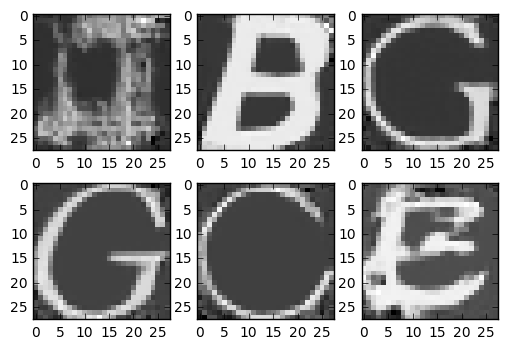

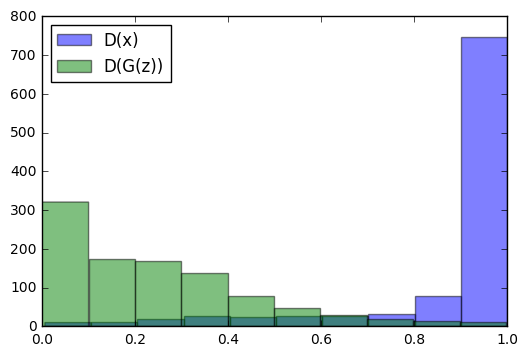

100%|██████████| 100000/100000 [2:34:15<00:00, 10.80it/s]


In [13]:
from IPython import display
from tqdm import tqdm
for epoch in tqdm(range(100000)):
    
    for i in range(5):
        d_loss = training.d_train_step(sample_data_batch(100), sample_noise_batch(100))
    
    g_loss = training.g_train_step(sample_noise_batch(100))
    
    if epoch %500==0:
        display.clear_output(wait=True)
        print("d loss =",d_loss)
        sample_images(2,3,True)
        sample_probas(1000)
        

### Load pre-trained GAN

Here you can load a pre-trained version of the network architecture from above.

To do so, just set load_weights to True and run the cell below.

In [36]:
#save the GAN:
save_weights=False
if save_weights:
    stored_params = get_all_param_values([generator.l_gen,discriminator.l_prob])
    np.savez("gan_weights.npz",stored_params)

#load the GAN:
load_weights=False
if load_weights:
    stored_params = np.load("gan_weights.npz",)['arr_0']
    set_all_param_values([generator.l_gen,discriminator.l_prob],stored_params)


### Sample output

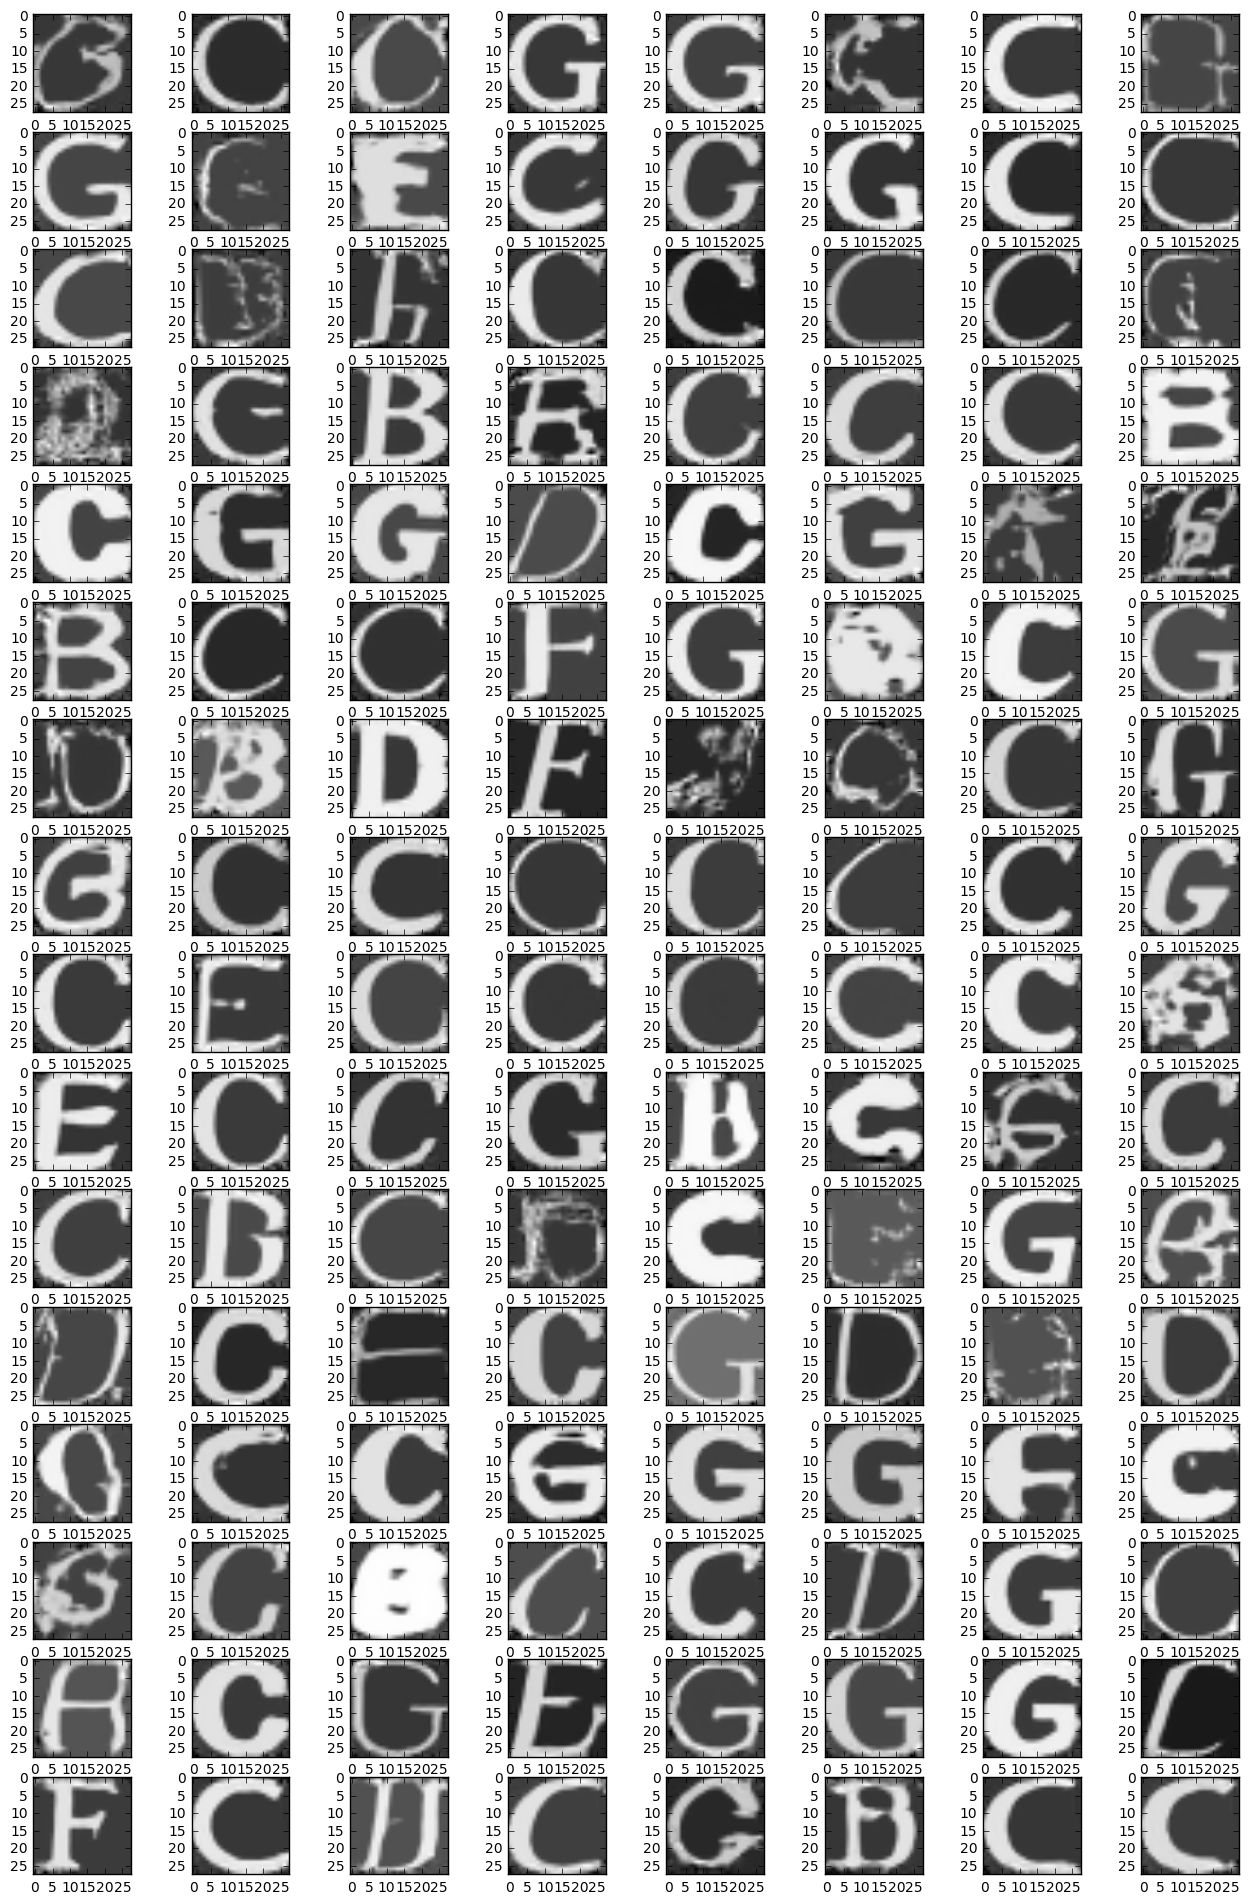

In [37]:
#The network was trained for 100k iterations
#Training for longer / with larger network may still yield better results.
plt.figure(figsize=[16,24])
sample_images(16,8)

### Authors:
* [Dmitry Emelyanenko](github.com/TIXFeniks/) - network architectures 
* [Dmitry Persiyanov](https://github.com/persiyanov) - loss functions & training pipeline 
* [jheuristic](http://github.com/justheuristic/) - descriptions and comments

[GoTo school](http://goto.msk.ru/) & [LAMBDA lab](https://cs.hse.ru/en/lambda/)